# exp037  
[Notion](https://www.notion.so/exp037-54ec5eb9f358496fbfe437c1f1ce4289?pvs=4)
exp036の推論を行い、セグメンテーションデータが存在する症例(data/dataset001/segmentation)に対するbodyのマスク画像の出力を行う.  


In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from typing import Tuple, Any

import albumentations as A
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')

from src.segmentation.dataset import save_df, TestDataset
from src.segmentation.trainer import evaluate
from src.image_processing import windowing
from src.logger import get_logger
from src.segmentation.model import load_models

# Config

In [2]:
class CFG:
    exp_name = 'exp_036'
    # model config
    backbone = 'efficientnet-b3'
    n_ch = 1
    n_class = 1
    # hyper params
    init_lr = 1e-3
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (512, 512)
    batch_size = 32
    amp = True
    n_epoch = 10
    # iteration_per_epoch = 200
    pretrain = True
    freeze_epochs = 0
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001/train_images"
    mask_dir = "data/dataset004/segmentations"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 0
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# create output dir
os.makedirs(os.path.join(CFG.model_save_dir, CFG.exp_name), exist_ok=True)

# get label correspondences
organ_index_dict_inv = {
    0: 'body'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# seed setting
def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

# logger setting
logger = get_logger(CFG)

# load dataframe
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_series_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')
df_seg_info_image = pd.read_csv("data/dataset001/seg_info_image.csv")
df_seg_info_series = pd.read_csv("data/dataset001/seg_info_series.csv")

In [4]:
def get_dataframe():
    """データセットのDataFrameを作成する.
    データセットによって内容を書き換える必要あり.
    """
    # df_train_series_metaをベースに、データフレームを構築.
    image_paths = []
    pid_list = []
    sid_list = []
    for i in range(len(df_train_series_meta)):
        sr = df_train_series_meta.iloc[i]
        pid, sid = sr["patient_id"], sr["series_id"]
        pid, sid = int(pid), int(sid)
        dir_ = f"data/dataset001/train_images/{pid}/{sid}"
        path_list = os.listdir(dir_)
        path_list = [[int(path.replace(".npy","")), path] for path in path_list]
        path_list.sort()
        path_list = [path[1] for path in path_list]
        for path in path_list:
            image_paths.append(os.path.join(dir_, path))
            pid_list.append(pid)
            sid_list.append(sid)
    # 画像データのDataFrameを作成
    df = pd.DataFrame({
            'image_path': image_paths,
            'patient_id': pid_list,
            'series_id': sid_list,
            })
    return df

df = get_dataframe()
# 必要
df["mask_path"] = None

# Load models

In [5]:
# モデルの読み込み
models = load_models(CFG, mode="final")

# Inference Code

In [31]:
def load_series_from_dataset(dir_: str)-> np.ndarray:
    """seriesを読み込む."""
    path_list = os.listdir(dir_)
    path_list = [[int(path.replace(".npy","")), path] for path in path_list]
    path_list.sort()
    path_list = [path[1] for path in path_list]
    arr = []
    for path in path_list:
        arr.append(np.load(os.path.join(dir_, path)))
    return np.array(arr)

def apply_preprocess(image: np.ndarray, mask: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
    """データ前処理. カスタマイズして使用.
    Args:
        image (numpy.ndarray): HU値のCT画像.
        mask (numpy.ndarray): channel lastのマスク画像.
    Returns:
        image (numpy.ndarray): windowing及び0~1に正規化.
        mask (numpy.ndarray): channel lastのマスク画像.
    """
    # 0~1に正規化
    image = windowing(image, wl=0, ww=400, mode="float32")
    return image, mask

def morpho_pytorch(masks):
    for c in range(masks.shape[-1]):
        with torch.no_grad():
            arr = torch.tensor(masks[...,c][np.newaxis]).to(CFG.device).to(torch.float32)
            #dialation
            arr = torch.nn.MaxPool3d(3, stride=1, padding=1, dilation=1, return_indices=False, ceil_mode=False)(arr)
            #erosion
            arr = -torch.nn.MaxPool3d(3, stride=1, padding=1, dilation=1, return_indices=False, ceil_mode=False)(-arr)
        arr = arr.squeeze(0).cpu().numpy().astype(np.uint8)
        masks[...,c] = arr
    return masks

def apply_postprocess(mask: np.ndarray)-> np.ndarray:
    """セグメンテーション後の臓器マスクの後処理.
    Args:
        mask (numpy.ndarray): (Z, H, W, C)のマスク画像.
    """
    mask = morpho_pytorch(mask)
    return mask

def evaluate_series(CFG: Any, df: pd.DataFrame, models: list, pid: int, sid: int) -> dict:
    """患者ごと(シリーズごと)の評価を行う.
    Args:
        CFG (Any): Config
        df (pd.DataFrame): get_training_dataframeによって作成したdf
        models (list): 学習済みモデルのリスト
        pid (int): 患者ID
        sid (int): シリーズID
    Returns:
        dict: 評価結果
    """
    # 評価用データセットの作成
    df_res = df[(df["patient_id"] == pid) & (df["series_id"] == sid)].reset_index(drop=True)
    if len(df_res) == 0:
        raise ValueError(f"pid:{pid}, sid:{sid} is not found.")
    ds = TestDataset(CFG, df_res, preprocess=apply_preprocess)
    eval_iterator = DataLoader(
        ds,
        shuffle=False,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers
    )
    # 推論
    result = evaluate(CFG, models, eval_iterator)
    return result

def resize_volume(mask: np.ndarray, hw_shape: tuple)-> np.ndarray:
    """h, wが512ではない場合にmaskをimageに合うようにリサイズする."""
    new_arr = []
    for i in range(mask.shape[0]):
        new_arr.append(cv2.resize(mask[i], hw_shape[::-1]))
    return np.stack(new_arr)

def create_bbox(mask: np.ndarray)->tuple[int, int, int, int]:
    """バイナリ画像からbboxを作成する.
    座標はcoco formatに合わせて、(x_min, y_min, w, h)とする.
    Args:
        mask (np.ndarray): (H, W)のバイナリ画像
    Returns:
        tuple(int, int, int, int): bbox
    """
    if mask.sum() == 0:
        return 0, 0, 0, 0
    # x_min
    x_min = np.where(np.any(mask, axis=0))[0].min()
    # x_max
    x_max = np.where(np.any(mask, axis=0))[0].max()
    # y_min
    y_min = np.where(np.any(mask, axis=1))[0].min()
    # y_max
    y_max = np.where(np.any(mask, axis=1))[0].max()
    return x_min, y_min, x_max-x_min, y_max-y_min

def load_bbox(sid: int, slice_num: int)-> list[int, int, int, int]:
    """slice_numのbboxを読み込む.
    Args:
        sid (int): シリーズID
        slice_num (int): スライス位置
    Returns:
        tuple[int, int, int, int]: bbox
    """
    with open(f"data/dataset004/body_bbox/{sid}/{slice_num}", "r") as f:
        bbox = f.read().split(" ")
        bbox = [int(b) for b in bbox]
    return bbox

def crop_image_from_bbox(image: np.ndarray, bbox: tuple[int, int, int, int])-> np.ndarray:
    """bboxを元に画像を切り出す.
    Args:
        image (np.ndarray): (H, W)の画像
        bbox (tuple[int, int, int, int]): bbox
    Returns:
        np.ndarray: 切り出した画像
    """
    x_min, y_min, w, h = bbox
    return image[y_min:y_min+h, x_min:x_min+w]

In [34]:
def inference() -> None:
    """学習用全データに対するセグメンテーション推論を行う.
    切り抜いた臓器のCT画像を保存する.
    保存は、f'{pid}_{sid}_{organ}.npy'という形式で、スライス位置などの情報を付加せずに外接矩形で保存.
    ボリュームサイズは制限せず、元の解像度で保存.
    """
    df_list = []
    for i in tqdm(range(len(df_train_series_meta))):
        pid, sid = df_train_series_meta.iloc[i][["patient_id", "series_id"]]
        pid, sid = int(pid), int(sid)
        result = evaluate_series(CFG, df, models, pid, sid)
        image_dir = f"data/dataset001/train_images/{pid}/{sid}"
        image = load_series_from_dataset(image_dir)
        pred = result["pred"] # (Z, H, W, C)
        pred = (pred > 0.5).astype(np.uint8)
        pred = apply_postprocess(pred)
        # imageが512x512でない場合はmask側をリサイズ
        if (image.shape[1], image.shape[2]) != CFG.image_size:
            pred = resize_volume(pred, image.shape[1:])

        ct_list = os.listdir(image_dir)
        ct_list = [int(path.replace(".npy","")) for path in ct_list]
        ct_list.sort()
        assert len(ct_list) == pred.shape[0]
        output_dir = f"data/dataset004/body_bbox/{sid}"
        os.makedirs(output_dir, exist_ok=True)
        for i, ct in enumerate(ct_list):
            bbox = create_bbox(pred[i])
            df_list.append([pid, sid, ct, bbox[0], bbox[1], bbox[2], bbox[3]])
    return df_list

In [35]:
df_list = inference()

In [37]:
bbox_df = pd.DataFrame(df_list, columns=["patient_id", "series_id", "slice_num", "x_min", "y_min", "w", "h"])

In [38]:
bbox_df.head()

,patient_id,series_id,slice_num,x_min,y_min,w,h
0,10004,21057,171,36,119,456,278
1,10004,21057,172,36,119,456,278
2,10004,21057,173,36,119,456,278
3,10004,21057,174,36,118,456,279
4,10004,21057,175,36,118,456,279


In [39]:
bbox_df.to_csv("data/dataset004/body_bbox.csv", index=False)

In [44]:
def get_bbox_from_df(sid: int, slice_num: int)-> list[int, int, int, int]:
    """slice_numのbboxを読み込む.
    Args:
        sid (int): シリーズID
        slice_num (int): スライス位置
    Returns:
        tuple[int, int, int, int]: bbox
    """
    df = bbox_df[(bbox_df["series_id"] == sid) & (bbox_df["slice_num"] == slice_num)]
    if len(df) == 0:
        return None
    bbox = df[["x_min", "y_min", "w", "h"]].values[0]
    return bbox

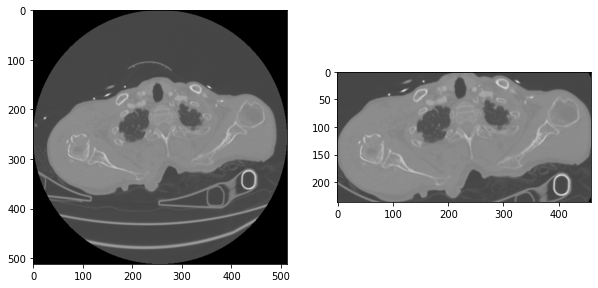

In [45]:
sid = 35894
pid = df_train_series_meta[df_train_series_meta["series_id"] == sid]["patient_id"].values[0]
slice_num = 55
impath = f"data/dataset001/train_images/{pid}/{sid}/{slice_num}.npy"
im = np.load(impath)
bbox = get_bbox_from_df(sid, slice_num)
cropped_im = crop_image_from_bbox(im, bbox)
# im, maskを並べて表示
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im, cmap="gray")
ax[1].imshow(cropped_im, cmap="gray")
plt.show()